# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:

In this project, the goal is to find a way conbines unsupervised and supervised method. The baselines are the methods to train the model with supervisored categories. The unsupervised section follows. The primary goal is to train a model that is able to classificate all the categories (labelled and unlabelled).

A classification model is trained under labelled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. They are Kmeans, Kmeans with PCA, Kmeans with Auto Encoder,Gaussian Mixture, Gaussian Mixture with PCA and Gaussian Mixture with Auto Encoder. these unlabelled categories will be labelled by the clustering methods and concatenate with other categories. The classification model will be trained again on the full dataset which contains the pre-labelled categories and new categories just labelled by the unsupervised methods. The result of the classification is drawn between all eight methods and an conclusion is given at the end.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

### Library
Several library functions are implemented. They are imported in the front of the next code block
pip install lightning-bolts

In [3]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load
from mylibs.transform import transform

In [ ]:
import torch
from torchvision import transforms
import os

In [11]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 5
NUM_WORKERS = 2
K = 7

In [12]:
device = torch.device("cuda" if USE_GPU else "cpu")



mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [13]:
def whole_flow(mode, useResnet):
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    return eval_metrics

## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.6028 Accuracy: 0.7905 F1_score: 0.7881
	Validation - Loss: 0.4575 Accuracy: 0.8248 F1_score: 0.8185
Epoch: 2
	Train      - Loss: 0.4155 Accuracy: 0.8492 F1_score: 0.8482
	Validation - Loss: 0.4109 Accuracy: 0.8510 F1_score: 0.8517
Epoch: 3
	Train      - Loss: 0.3726 Accuracy: 0.8650 F1_score: 0.8642
	Validation - Loss: 0.3801 Accuracy: 0.8586 F1_score: 0.8592
Epoch: 4
	Train      - Loss: 0.3446 Accuracy: 0.8770 F1_score: 0.8763
	Validation - Loss: 0.3611 Accuracy: 0.8662 F1_score: 0.8656
Epoch: 5
	Train      - Loss: 0.3241 Accuracy: 0.8844 F1_score: 0.8839
	Validation - Loss: 0.3546 Accuracy: 0.8681 F1_score: 0.8649


<Figure size 432x288 with 0 Axes>

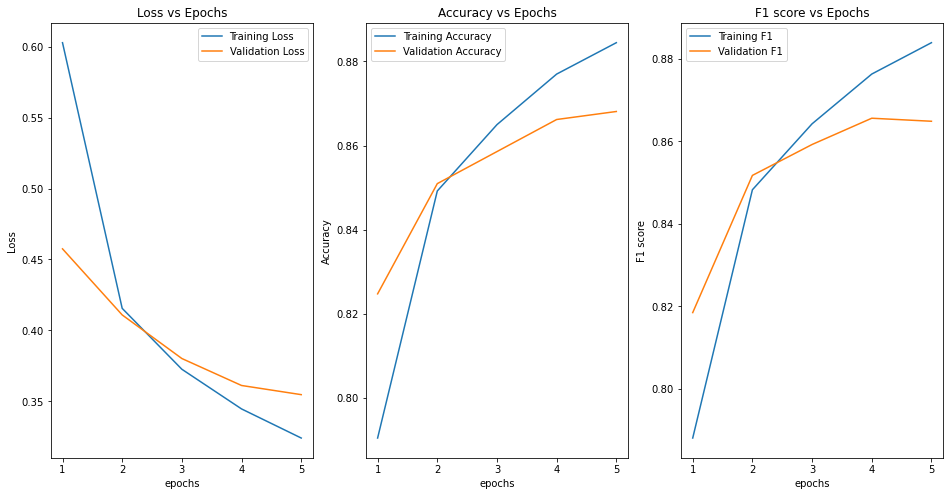

Loading model at epoch 4 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3807 Accuracy: 0.8581 F1_score: 0.8550
Result on unlabelled test set: Loss: 9.9499 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.2542 Accuracy: 0.6007 F1_score: 0.5159


In [14]:
mode_metric = whole_flow(6, False)
mode_metrics[6] = mode_metric

## Baseline #2, use full Fashion-MNIST dataset to train

In [ ]:
mode_metric = whole_flow(7, False)
mode_metrics[7] = mode_metric

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(0, False)
mode_metrics[0] = mode_metric

## Approach #2, use KMeans with PCA to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(1, False)
mode_metrics[1] = mode_metric

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(2, False)
mode_metrics[2] = mode_metric

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(3, False)
mode_metrics[3] = mode_metric

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(4, False)
mode_metrics[4] = mode_metric

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

In [ ]:
mode_metric = whole_flow(5, False)
mode_metrics[5] = mode_metric

In [ ]:
report_summary(mode_metrics, mode_description_short)

## Conclusion